# Comptage de particules sphériques sur une image MEB/optique

**<font size="10"><span style="color: #c9401e">Import des différents packages</span></font>**

In [1]:
import sys
import cv2 as cv
import numpy as np  
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.image as mpimg
import re
import tkinter
from tkinter import filedialog
import os
from PIL import Image
from PIL.ExifTags import TAGS

**<font size="10"><span style="color: #c9401e">Chargement et lecture de l'image</span></font>**

C:/Users/duclosr/Desktop/RDU-012-7_06.bmp


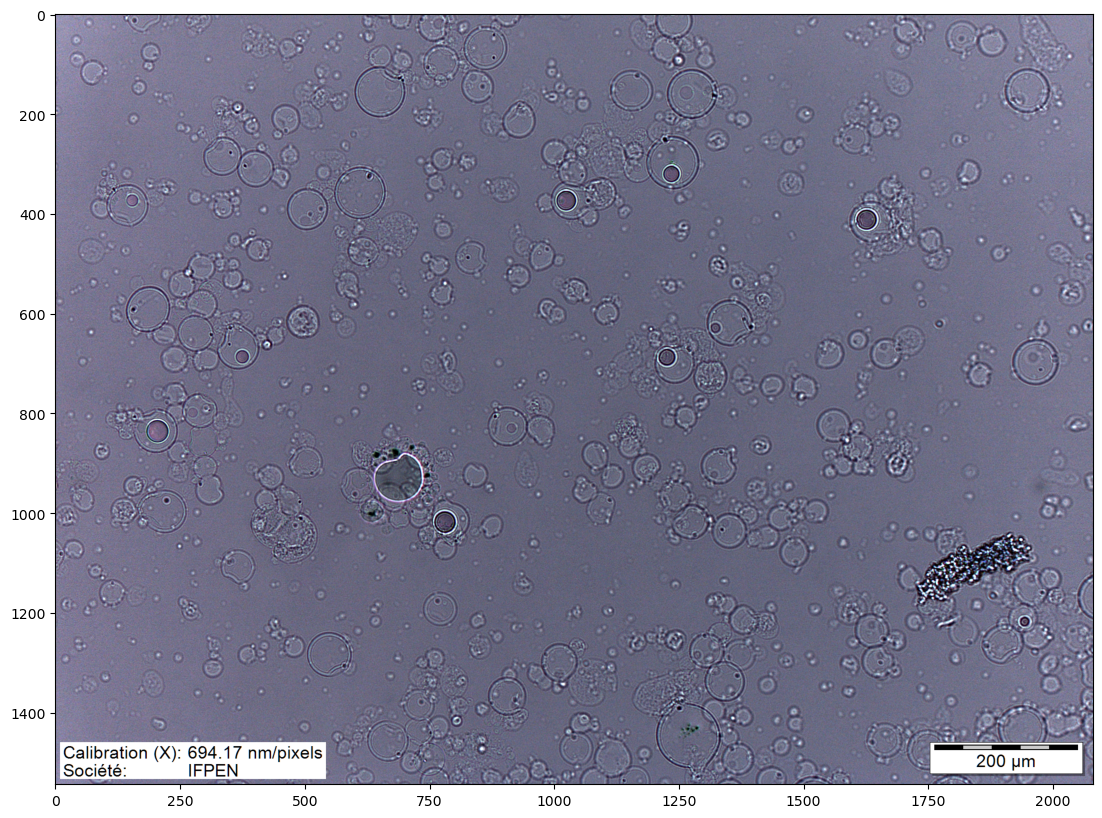

In [3]:
root = tkinter.Tk()
root.withdraw() # Use to hide tkinter window

currdir = os.getcwd()
# path = filedialog.askdirectory(parent=root, initialdir=currdir, title='Please select a directory') # Select a directory
path = filedialog.askopenfilename(parent=root, initialdir=currdir, title='Please select a file') # Select a file
if len(path) > 0:
    print(path)
    file_name = path.split('/')[-1].split('.')[0]
    default_file = path
    img = cv.imread(default_file)
    #img = img[0:1400, 0:4000] #on peut éventuellement cropper l'image pour l'affichage
    fig, ax = plt.subplots(figsize=(30,10))
    image = ax.imshow(img)

**<font size="10"><span style="color: #c9401e">Définition de la fonction permettant de trouver les cercles sur l'image</span></font>**

In [4]:
# scale initialization
scl = 694.17

num_object = 0
d_moyen = 0
ecart_type = 0
d_10 = 0
d_50 = 0
d_90 = 0

def plot_circles(definition, param1, param2,minRadius, maxRadius, echelle): 
    
    
    image = cv.imread(default_file)
    
    
    src = image[0:1400,:] #on peut cropper l'image pour l'analyse
    #src = 255 - src
    #rc = image
    
    if src is None:
        print ('Error opening image!')
        print ('Usage: hough_circle.py [image_name -- default ' + default_file + '] \n')
    gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    gray = cv.medianBlur(gray, 5) #blur obligatoire pour analyse de l'image
    rows = gray.shape[0]
    #fig, ax = plt.subplots(figsize=(10, 10))
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,gridspec_kw={  #création des graphes sur 1 ligne, 2 colonnes
                           'width_ratios': [1,1],
                           'height_ratios': [2]}, figsize=(30,10))

    
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, 1.5, rows / definition, #algorithme de Hough circulaire pour détection des sphères, cf aide sur openCV
                               param1=param1, param2=param2,
                               minRadius=minRadius, maxRadius=maxRadius)

    if circles is not None:
        circles = np.uint16(np.around(circles)) #objet avec coord du centre et rayons des cercles
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle center
            cv.circle(src, center, 1, (0, 100, 100), 3) # on trace
            # circle outline
            radius = i[2]
            cv.circle(src, center, radius, (255,255,255), 2) # on trace
    else: 
        print('fail')
   
    rayons = []
    for i in circles[0,:]:
        rayons.append(i[2])
    
    d_µm = [2*i*echelle/1000 for i in rayons] #on trace l'histogramme en diametre

    global num_object, d_moyen, ecart_type, d_10, d_50, d_90
    num_object_prev = num_object
    d_moyen_prev = d_moyen
    ecart_type_prev = ecart_type
    d_10_prev = d_10
    d_50_prev = d_50
    d_90_prev = d_90

    num_object = len(rayons)
    d_moyen = round(sum(d_µm)/len(d_µm),1)
    ecart_type = round(np.std(d_µm),1)
    d_10 = round(np.percentile(d_µm, 10), 1)
    d_50 = round(np.percentile(d_µm, 50), 1)
    d_90 = round(np.percentile(d_µm, 90), 1)

    d_moyen_text = r"$d_{mean} = $" + str(d_moyen) + " " + r"$\mu$m"
    d_10_text = r"$d_{10} = $" + str(d_10) + " " + r"$\mu$m"
    d_50_text = r"$d_{50} = $" + str(d_50) + " " + r"$\mu$m"
    d_90_text = r"$d_{90} = $" + str(d_90) + " " + r"$\mu$m"

    textstr = '\n'.join((
    d_moyen_text,
    r'$\sigma=%.1f$' % ecart_type,
    d_10_text,
    d_50_text,
    d_90_text))

    ax1.imshow(src)
    ax1.set_title("Number of counted objects : %i" % num_object, fontsize=20)
    ax2.hist([d_µm], edgecolor='black', bins=np.linspace(0, np.max(d_µm), num=20))
    props = dict(boxstyle='round', alpha=0.5, facecolor='white')
    ax2.text(1.05, 0.9, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)
    ax2.set_xlabel('Diameter (µm)', fontsize=18)
    ax2.set_ylabel('Number of capsules', fontsize=18)
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    
 

    print('\n')
    print(" Nombre d'objets comptés : {} (prev. {})  |  Diamètre moyen : {} (prev. {}) µm  |  Écart-type : {} (prev. {}) \n D10 = {} (prev. {}) µm  |  D50 = {} (prev. {}) µm  |  D90 = {} (prev. {}) µm".format(num_object, num_object_prev, d_moyen, d_moyen_prev, ecart_type, ecart_type_prev, d_10, d_10_prev, d_50, d_50_prev, d_90, d_90_prev))
    print('\n')

    full_figure = file_name + " full_figure.png"
    hist = file_name + " hist.png"
    fig.savefig(full_figure, bbox_inches='tight')
    plt.show()

    plt.plot(figsize=(16,9))
    plt.hist([d_µm], edgecolor='black', bins=np.linspace(0, np.max(d_µm), num=20))
    plt.text(1.45, 3.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    plt.xlabel('Diameter (µm)', fontsize=10)
    plt.ylabel('Number of capsules', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig(hist, dpi=600, bbox_inches='tight')
    plt.close()
    

**<font size="10"><span style="color: #c9401e">Création des widgets interactifs</span></font>**

In [5]:
definition = widgets.IntSlider(
    value=100,
    min=0,
    max=200,
    step=10,
    description='definition ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
param1 =widgets.IntSlider(
    value=300,
    min=0,
    max=500,
    step=10,
    description='param1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
param2 = widgets.FloatSlider(
    value=0.85,
    min=0.5,
    max=1,
    step=0.05,
    description='param2:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)
minRadius =widgets.IntSlider(
    value=1,
    min=0,
    max=10,
    step=1,
    description='minRadius:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
maxRadius = widgets.IntSlider(
    value=70,
    min=0,
    max=100,
    step=1,
    description='maxRadius:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
echelle = widgets.BoundedFloatText(
    value=scl,
    min=0,
    max=2000.0,
    step=0.1,
    description='echelle (nm/px):',
    disabled=False
)
legend1 = widgets.Textarea(
    value="Distance minimale entre les centres des cercles détectés. Si le paramètre est trop grand, plusieurs cercles voisins peuvent être faussement détectés en plus d'un vrai cercle. S'il est trop petit, certains cercles peuvent ne pas être détectés.",
    placeholder='Type something',
    description='definition:',
    disabled=False,
    layout = widgets.Layout(width='1800px')   
)
legend2 = widgets.Textarea(
    value="Seuil transmis au détecteur de contours de Canny.",
    placeholder='Type something',
    description='param1:',
    disabled=False,
    layout = widgets.Layout(width='1800px')   
)
legend3 = widgets.Textarea(
    value="Mesure de la perfection des cercles. Plus elle est proche de 1, plus l'algorithme sélectionne des cercles de meilleure forme. Dans la plupart des cas, une valeur de 0,9 devrait suffire. Si vous souhaitez obtenir une meilleure détection des petits cercles, vous pouvez la réduire à 0,85, 0,8 ou même moins. Mais essayez également de limiter la plage de recherche [minRadius, maxRadius] pour éviter de nombreux faux cercles.",
    placeholder='Type something',
    description='param2:',
    disabled=False,
    layout = widgets.Layout(width='1800px')   
)


ui1 = widgets.HBox([definition, param1, param2])
ui2 = widgets.HBox([minRadius, maxRadius, echelle])
ui3 = widgets.VBox([ui1,ui2])

out = widgets.interactive_output(plot_circles, {'definition': definition, 'param1': param1, 'param2': param2, 'minRadius': minRadius, 'maxRadius':maxRadius, 'echelle':echelle})

display(ui3, out, legend1, legend2, legend3)

Output()

Textarea(value="Distance minimale entre les centres des cercles détectés. Si le paramètre est trop grand, plus…

Textarea(value='Seuil transmis au détecteur de contours de Canny.', description='param1:', layout=Layout(width…

Textarea(value="Mesure de la perfection des cercles. Plus elle est proche de 1, plus l'algorithme sélectionne …